# Propeller identification
We want to charchterize the transfer function of a drone propeller (BLDC motor) by measuring a set of datapoints and applying machine learning techniques to approximate the parameters

## Collection of the data points
We collect data by interfacing the computer and the board via a serial port.
In the PC side we use the pySerial library

In [25]:
import serial   # pip install pyserial, not pip install serial !

# Serial port parameters
port = '/dev/ttyUSB0'   # Depends on the OS
baud = 115200
timeout = 1

# Open te serial port
ser = serial.Serial(port, baud, timeout=timeout)
ser.flush()

We now define two function to simplify reading and writing data via the serial port.
Note that this is specific to this particular setup.

In [26]:
# Returns a string, already decoded and polished
def my_readline():
    line = ser.readline().decode('ascii').strip()
    return line

# Writes a message, following the protocol we defined:
# <message>
def my_write(message):
    ser.write(("<"+message+">").encode())

To get the data, we first must send a message to the board to tell how to measure. We have to send:
- the command: what we want to do
- the step: the distance between each input value. Can be negative
- the max pwm value to test
- the number of samples per input value

After that, the board will start the test and will send back data, line by line.
Each line sent by the board is a sample, already formatted to be written in a .csv file.
While we read the data, we also write it into a .csv file to store all the samples.

In [27]:
import csv

# Given the parameters, build the message string
def build_message(command, n_samples, step, max_pwm):
    # The words are separated by a space
    message = " ".join([command, str(n_samples), str(step), str(max_pwm)])
    return message

def build_message(list_of_string):
    message = " ".join(list_of_string)
    return message

# Given a message and a filename, send the message and store the data in the specified file
def get_dataset(message, filename):
    ser.flush()
    # Open the file
    file = open(filename, 'a')
    file.truncate(0)

    # Setup the csv
    csv_writer = csv.writer(file)

    # Send the command to get the measurements
    my_write(message)

    # Listen to the response
    while 1:
        # Read a line = a row of the matrix S = a sample
        line = my_readline()

        # Check if the line is empty => skip
        if line == '':
            continue

        # If there is something, I check if it is the termination message
        if line == "Finished":
            file.close()
            print("Finished")
            break

        # Forced stop
        if line == 'STOP':
            file.close()
            print("Stopped")
            break

        # Exception unhandled
        if line == 'Arduino is ready':
            print("Exception occured")
            break

        # If I'm here it is a proper sample
        values = line.split(',')
        print(values[0], end=' ')
        csv_writer.writerow(values)

Finally we can collect the data

In [28]:
# Collect the data for the ramp
command = 'R'   # Measure
n_samples = 10  # How many samples do I want to average for each input value
step = 5      # Step for the input signal
min_pwm = 1180   # Start from here
max_pwm = 1800 # Max value to test
filename = "Dataset_ramp.csv"
get_dataset(build_message([command, str(n_samples), str(step), str(min_pwm), str(max_pwm)]), filename)

PWM 1180.00 1190.00 1200.00 1210.00 1220.00 1230.00 1240.00 1250.00 1260.00 1270.00 1280.00 1290.00 1300.00 1310.00 1320.00 1330.00 1340.00 1350.00 1360.00 1370.00 1380.00 1390.00 1400.00 1410.00 1420.00 1430.00 1440.00 1450.00 1460.00 1470.00 1480.00 1490.00 1500.00 1510.00 1520.00 1530.00 1540.00 1550.00 1560.00 1570.00 1580.00 1590.00 1600.00 1610.00 1620.00 1630.00 1640.00 1650.00 1660.00 1670.00 1680.00 1690.00 1700.00 Stopped


## Plot
After collecting the data, we draw a beautiful plot.

Before actually drawing the plot, we have to get the data from the file we created

In [29]:
import pandas
data_frame = pandas.read_csv(filename)
print(data_frame.tail())

       PWM       RPM  Thrust
48  1660.0  8906.830   0.661
49  1670.0  8937.757   0.683
50  1680.0  9085.394   0.697
51  1690.0  9211.229   0.711
52  1700.0  9249.973   0.733


<AxesSubplot: xlabel='RPM', ylabel='Thrust'>

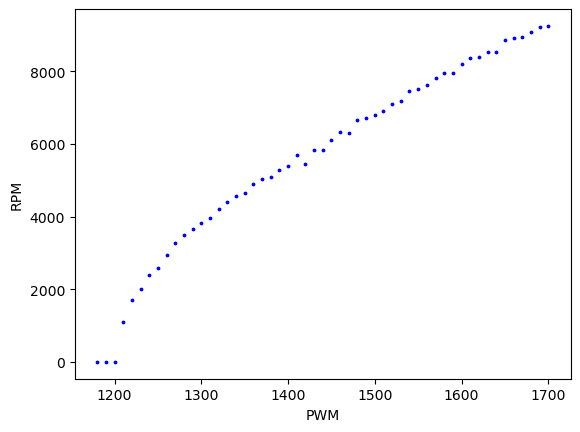

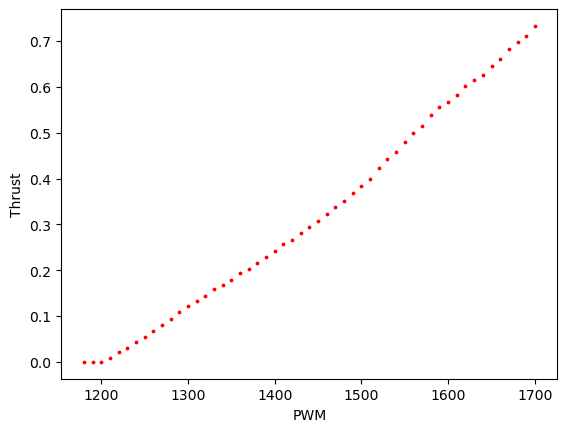

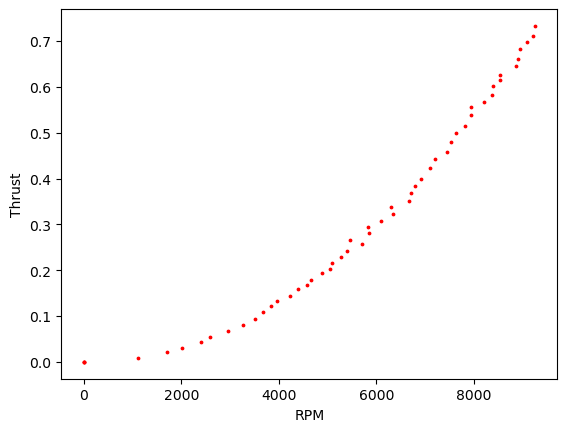

In [30]:
# https://matplotlib.org/stable/tutorials/introductory/quick_start.html#sphx-glr-tutorials-introductory-quick-start-py
import matplotlib as mpl
import matplotlib.pyplot as plt

data_frame.plot(x='PWM', y='RPM', kind='scatter', s=3, c='blue')
data_frame.plot(x='PWM', y='Thrust', kind='scatter', s=3, c='red')
data_frame.plot(x='RPM', y='Thrust', kind='scatter', s=3, c='red')

## Step response
Now we measure the step response of the propeller.

The value at which we measure it coincides with the chosen operating point in the final system.

Additionally, we indicate to the board which interval to measure.

In [31]:
command = 'S'
step_value = 1400
n_samples = 1000
max_time = 3000    # milliseconds
filename = 'Dataset_step.csv'

#get_dataset(build_message([command, str(step_value), str(max_time)]), filename)

In [32]:
data_frame_step = pandas.read_csv(filename)
print(data_frame_step.tail())
data_frame_step.plot(x='T', y='RPM', kind='line', c='blue')

EmptyDataError: No columns to parse from file